# Transfer Learning in Keras

In this notebook, we will implement transfer learning in Python using the pre-trained ResNet model. We will run two experiments - 1. **Freezing the base model weights**, adding a few layers to it at the end (fully connected etc.) and training the newly added layers, and 2. **Freezing the first 140 layers of ResNet** and retraining the rest.

Apart from this, you will learn **two important practical preprocessing techniques** in this notebook - **data augmentation** and **data generators**. The notebook is dividede into the following sections:
1. Importing libraries
2. Splitting into train and test set
3. Importing the pretrained ResNet model
4. Data Generators: Preprocessing and Generating Batch-Wise Data (On the Fly)
5. Training the Base Model (Using Batch-Wise Data Generation)
6. Freezing the initial-n layers and training the rest


In [28]:
# For downloading the dataset
# Go to Kaggle.com -> My Account -> Create new API Token -> Upload kaggle.json in Jupyter Home
#!mkdir ~/.kaggle
#!cp ../kaggle.json ~/.kaggle/kaggle.json
#!chmod 600 ~/.kaggle/kaggle.json
#!kaggle config set -n proxy -v http://10.150.0.3:3128
#!kaggle datasets download -d alxmamaev/flowers-recognition
#!unzip flowers-recognition.zip
#!rm flowers-recognition.zip

### Importing Libraries

In [29]:
# !pip install keras

In [30]:
# import libraries
import os
import shutil
import numpy as np
import glob   
import keras.backend as K
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalAveragePooling2D
from keras.models import Model, load_model
from keras import optimizers
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
import scipy.misc
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input

# for reading images
from matplotlib.pyplot import imshow
%matplotlib inline

# channels last is the format used by tensorflow 
K.set_image_data_format('channels_last')
K.set_learning_phase(1)


### Splitting Into Train and Test

Let's now split the data into train and test directories. Firstly, note that the most common way to organize (images) data is to create two/three directories - train and test (or validation) having n-subdirectories, each subdirectory being a class (here, five subdirs for the five flower types).

The following function creates two directories - train and test, each having five subdirectories (sunflower, dandelion, rose, tulip, daisy).

In [31]:
# set to where the 'flowers' directory is located
data_dir = 'flowers'

# Training data dir
training_dir = 'Train'

# Test data dir
testing_dir = 'Test'

# Ratio of training and testing data
train_test_ratio = 0.8 


def split_dataset_into_test_and_train_sets(all_data_dir = data_dir, training_data_dir = training_dir, testing_data_dir=testing_dir, train_test_ratio = 0.8):

    # recreate test and train directories if they don't exist
    if not os.path.exists(training_data_dir):
        os.mkdir(training_data_dir)

    if not os.path.exists(testing_data_dir):
        os.mkdir(testing_data_dir)               
    
    num_training_files = 0
    num_testing_files = 0

    # iterate through the data directory 
    for subdir, dirs, files in os.walk(all_data_dir):
        
        category_name = os.path.basename(subdir)

        if category_name == os.path.basename(all_data_dir):
            continue

        training_data_category_dir = training_data_dir + '/' + category_name
        testing_data_category_dir = testing_data_dir + '/' + category_name
        
        # creating subdirectory for each sub category
        if not os.path.exists(training_data_category_dir):
            os.mkdir(training_data_category_dir)   

        if not os.path.exists(testing_data_category_dir):
            os.mkdir(testing_data_category_dir)
            
        file_list = glob.glob(subdir + '/*.jpg')

        print(str(category_name) + ' has ' + str(len(files)) + ' images') 
        random_set = np.random.permutation((file_list))
        
        # copy percentage of data from each category to train and test directory
        train_list = random_set[:round(len(random_set)*(train_test_ratio))] 
        test_list = random_set[-round(len(random_set)*(1-train_test_ratio)):]
        
        for lists in train_list : 
            shutil.copy(lists, training_data_dir + '/' + category_name + '/' )
            num_training_files += 1
  
        for lists in test_list : 
            shutil.copy(lists, testing_data_dir + '/' + category_name + '/' )
            num_testing_files += 1
  

    print("Processed " + str(num_training_files) + " training files.")
    print("Processed " + str(num_testing_files) + " testing files.")

In [32]:
# split into train and test directories
split_dataset_into_test_and_train_sets()

rose has 784 images
daisy has 769 images
sunflower has 734 images
tulip has 984 images
dandelion has 1055 images
Processed 3458 training files.
Processed 865 testing files.


### Importing the Pre-Trained Model 

Let's now import the pretrained ResNet model. In the first experiment, we will use the pretrained weights (from Imagenet) of ResNet. The argument `include_top = False` specifies that we do not want to import the top layers (the last ones, which are typically pooling, FC, softmax etc.). We'll add some of our own last layers (a global average poooling layer and a final softmax) and train just those.

In [33]:
# number of classes 
num_classes = 5

def get_model():
    
    # Get base model: ResNet50 
    base_model = ResNet50(weights='imagenet', include_top=False)
    
    # freeze the layers in base model
    for layer in base_model.layers:
        layer.trainable = False
        
    # Get the output from the base model 
    base_model_ouput = base_model.output
    
    # Adding our own layers at the end
    # global average pooling: computes the average of all values in the feature map
    x = GlobalAveragePooling2D()(base_model_ouput)
    
    # fully connected and 5-softmax layer
    x = Dense(512, activation='relu')(x)
    x = Dense(num_classes, activation='softmax', name='fcnew')(x)
    
    model = Model(inputs=base_model.input, outputs=x)
    return model

In [34]:
# Get the model
model = get_model()

# compile it
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# summary of model
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, None, None, 6 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

Notice that the total number of parameters in the model is about 24 million, though the number of trainable parameters is only about 1 million.

Let's now see how we'll feed the data to the model.

### Data Generators: Preprocessing and Generating Batch-Wise Data (On the Fly)

We will now implement an incredibly useful preprocessing technique - **data augmentation** using **data generators**.

You will learn preprocessing techniques in detail in the next industry session, though they're quire easy to understand anyway. Here's a quick overview.

**Data Augmentation** is a commonly used technique in image processing used to 'create' more training data. It basically modifies the original training images a bit (e.g. rotates them by a few degrees, changes the colour shades a little, etc.) to 'create' (or augment) new training images. The basic reason to do this is to **increase the amount of variance** in the training data. It is possible to do this with images because if you rotate the image of (say) a dog (or change the colours a bit, stretch the image horizontally etc.), it stays a dog. Thus, you can create many images from each training image while the label stays the same.

In the code below, we have specified the augmentation techniques as `shear_range=0.2, zoom_range=0.2, horizontal_flip=True`. Shear 'stretches' the images, zoom_range zooms them in, and horizontal_flip 'flips' them around horizontally.

Now, in the code below, you will notice that we have something called `ImageDataGenerator` - lets understand what it does.

**Data generators** are used to **feed data points in batches** to the model. The main reason to use them is that they are efficient (compared to feeding one data point at a time, or all of them at once which will require a lot of memory). What's cooler about them is that they (at least in keras) can preprocess the images and create augmented ones *on the fly*, i.e. as the batches are fed to the model, the augmented images are created and preprocessed. This eliminates the need to store the augmented images separately.

An important point to note is that you **never augment the validation or test sets**, only the training set. This is because test (and validation) sets are supposed to be representative of the real images you'll get in the real world. However, you do apply basic preprocessing to validation and test sets (scaling/centering them etc.).

In the code below, the method `flow_from_directory` 'flows' the data in batches from the training and test directories. It is an instance of `ImageDataGenerator` where we specify the preprocessing and augmentation techniques that we want to use. In this case, we are just using the standard preprocessing techniques that come with the `preprocess_input` module in keras.

You can <a href="https://keras.io/preprocessing/image/">read about data generators here</a>.

In [35]:
# Using ImageDataGenerator for pre-processing

image_size = 224
batch_size = 64

# help(ImageDataGenerator)
train_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input, 
                                    shear_range=0.2, zoom_range=0.2, 
                                    horizontal_flip=True)

# do only basic preprocessing for validation data (no data augmentation)
valid_data_gen = ImageDataGenerator(preprocessing_function = preprocess_input)

# create data generator objects
train_generator = train_data_gen.flow_from_directory(training_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')
valid_generator = valid_data_gen.flow_from_directory(testing_dir, (image_size,image_size), batch_size=batch_size, class_mode='categorical')

Found 4142 images belonging to 5 classes.
Found 1549 images belonging to 5 classes.


Note that the number of training and validation images is increased (because of data augmentation).

### Training the Base Model (Using Batch-Wise Data Generation)

Let's now train the model. When we use data generators, we use the `model.fit_generator` method rather than the usual `model.fit`.

In [36]:
# Training the newly added layers 
epochs = 5

# flow data (in batches) from directories (while simultaneously preprocessing/augmenting
model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//batch_size,
    epochs=epochs,
    verbose=1)

Epoch 1/5
64/64 [==============================] - 39s 612ms/step - loss: 0.8206 - acc: 0.7236 - val_loss: 0.4856 - val_acc: 0.8496
Epoch 2/5
64/64 [==============================] - 32s 499ms/step - loss: 0.4482 - acc: 0.8582 - val_loss: 0.3609 - val_acc: 0.8835
Epoch 3/5
64/64 [==============================] - 31s 492ms/step - loss: 0.3692 - acc: 0.8700 - val_loss: 0.3006 - val_acc: 0.9037
Epoch 4/5
64/64 [==============================] - 32s 501ms/step - loss: 0.3289 - acc: 0.8887 - val_loss: 0.2870 - val_acc: 0.8997
Epoch 5/5
64/64 [==============================] - 32s 504ms/step - loss: 0.2913 - acc: 0.9063 - val_loss: 0.2438 - val_acc: 0.9239


### Freezing the Initial-n Layers and Training the Rest

Let's now try another variant of transfer learning. We will freeze the first 140 layers of ResNet (with the hypopthesis that they have learnt to extract some useful generic features from their ImageNet experience) and train the rest of the layers.

In [37]:
epochs = 10

# training the model after 140 layers
split_at = 140
for layer in model.layers[:split_at]: layer.trainable = False
for layer in model.layers[split_at:]: layer.trainable = True
    
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])

# Choosing lower learning rate for fine-tuning
# learning rate is generally 10-1000 times lower than normal learning rate when we are fine tuning the initial layers
sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

import time

start_time = time.time()
history = model.fit_generator(
    train_generator,
    steps_per_epoch=train_generator.n//batch_size,
    validation_data=valid_generator,
    validation_steps=valid_generator.n//batch_size,
    epochs=epochs,
    verbose=1)

end_time = time.time()

Epoch 1/10
64/64 [==============================] - 38s 594ms/step - loss: 0.2607 - acc: 0.9130 - val_loss: 0.1952 - val_acc: 0.9434
Epoch 2/10
64/64 [==============================] - 33s 521ms/step - loss: 0.2116 - acc: 0.9305 - val_loss: 0.1787 - val_acc: 0.9354
Epoch 3/10
64/64 [==============================] - 33s 515ms/step - loss: 0.1579 - acc: 0.9505 - val_loss: 0.1337 - val_acc: 0.9562
Epoch 4/10
64/64 [==============================] - 33s 510ms/step - loss: 0.1328 - acc: 0.9598 - val_loss: 0.1117 - val_acc: 0.9623
Epoch 5/10
64/64 [==============================] - 34s 527ms/step - loss: 0.1105 - acc: 0.9687 - val_loss: 0.0939 - val_acc: 0.9737
Epoch 6/10
64/64 [==============================] - 33s 515ms/step - loss: 0.0927 - acc: 0.9733 - val_loss: 0.0775 - val_acc: 0.9778
Epoch 7/10
64/64 [==============================] - 33s 516ms/step - loss: 0.0719 - acc: 0.9824 - val_loss: 0.0717 - val_acc: 0.9811
Epoch 8/10
64/64 [==============================] - 33s 516ms/step - 

In [38]:
print(f'Training complete. Time Taken {end_time - start_time}')

Training complete. Time Taken 339.83733892440796


dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


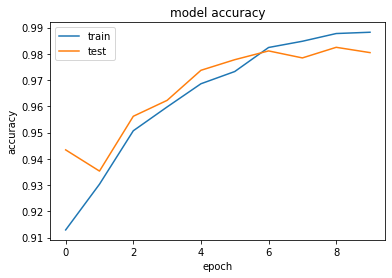

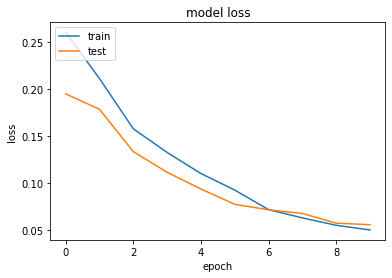

In [39]:
from matplotlib import pyplot as plt

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()